In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, UpSampling2D, ReLU

In [2]:
def bottle_block(x,units=64,kernel=3):
    out = conv_block(x,units,kernel,1)
    out = Conv2D(units,kernel,1,padding="same")(out)
    out = BatchNormalization()(out)
    out = out + x
    out = ReLU()(out)
    return out

def conv_block(x,units,kernel=3,stride=1,activation=ReLU):
    out = Conv2D(units,kernel,stride,padding="same")(x)
    out = BatchNormalization()(out)
    out = activation()(out)
    return out

def up_block(x,units=64,kernel=3):
    out = UpSampling2D(2,interpolation="bilinear")(x)
    out = conv_block(out,units,kernel,1)
    return out

def down_block(x,units=64,kernel=3):
    out = conv_block(x,units,kernel,2)
    out = conv_block(out,units,kernel,1)
    return out

NameError: name 'ReLU' is not defined

In [10]:
def generator(input_shape,units=64,layers=1,num_blocks=6,out_channels=6):
    x = keras.layers.Input(input_shape)
    g2 = conv_block(x,units,7,1)
    temp = units
    skip = []
    for i in range(0,layers):
        g2 = down_block(g2,temp*2,3)
        skip.append(g2)
        temp *=2
    
    #code for local enhancer network
    #not sure if needed to access local network output for training
    local = None
    for i in range(0,layers):
        g2 = skip[-1-i]
        local = g2
        for j in range(0,num_blocks):
            local = bottle_block(local,temp)
        local = g2 + local
        temp = temp//2
        local = up_block(local,temp)
    
    g2 = local
    for i in range(0,num_blocks):
        g2 = bottle_block(g2,units)
    g2 = conv_block(g2,out_channels,7)
    g2 = tf.keras.activations.tanh(g2)
    return keras.Model(x,g2)

In [ ]:
def unet(input_shape,n_units,levels,classes):
    inputs = keras.layers.Input(shape=(input_shape))
    output = inputs
    units = n_units
    #create array to store skip tensors
    level = []
    #Create contracting path
    for i in range(0,levels):
        output = keras.layers.Conv2D(units,3,strides=1,padding='same',activation='relu')(output)
        output = keras.layers.Conv2D(units,3,strides=1,padding='same',activation='relu')(output)
        #output = keras.layers.Dropout(0.1)(output)
        level.append(output)
        output = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid")(output)
        units = units * 2
        
    #Create expansion path    
    for i in range(0,levels):
        output = keras.layers.Conv2D(units,3,strides=1,padding='same',activation='relu')(output)
        output = keras.layers.Conv2D(units,3,strides=1,padding='same',activation='relu')(output)
        output = keras.layers.UpSampling2D(size =(2,2),interpolation="bilinear")(output)
        units = units//2
        output = keras.layers.Conv2D(units,2,padding='same')(output)
        output = tf.concat([level[-1-i],output],axis=3)
    
    #outputting segmentation map
    output = keras.layers.Conv2D(units,3,strides=1,padding='same',activation='relu')(output)
    output = keras.layers.Conv2D(units,3,strides=1,padding='same',activation='relu')(output)
    output = keras.layers.Conv2D(classes,1,padding='same',activation='softmax')(output)
    model = keras.Model(inputs,output)
    return model

In [27]:
def discriminator(x,n_units=64,layers=3):
    temp = n_units
    out = Conv2D(temp,4,2,padding="same")(x)
    out = LeakyReLU()(out)
    for i in range(1,layers):
        temp = n_units*2
        out = conv_block(out,temp,4,2,activation=LeakyReLU)
    temp = n_units*2
    out = conv_block(out,temp,4,1,activation=LeakyReLU)
    out = Conv2D(1,4,1,padding="same")(out)
    out = keras.layers.Flatten()(out)
    out = keras.activations.sigmoid(out)
    return keras.Model(x,out)

In [ ]:
def multiscale_discriminator(input_shape):
    inputs = keras.layers.Input(input_shape)
    out = None
    return keras.Model(inputs,out)

In [8]:
vgg = keras.applications.vgg19.VGG19(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)
pixel_weight = 0.1
perceptual_weight = 1
adversarial_weight = 0.001
segmentation_weight = 0.1
reconstruction_weight = 1
stepwise_weight = 1


In [13]:
def perceptual_loss(y_true, y_pred):
    x = tf.image.resize(y_true,(224,224))
    y = tf.image.resize(y_pred,(224,224))
    x_vgg = vgg.predict(x)
    y_vgg = vgg.predict(y)
    loss = 0
    loss +=  keras.losses.MeanAbsoluteError(x_vgg,y_vgg)
    return loss
def pixel_loss(x, y):
    return keras.losses.MeanAbsoluteError(x,y)
    
def reconstruction_loss(x, y):
    loss = 1*perceptual_loss(x,y) + 0.1*pixel_loss(x,y)
    return loss
def adversarial_loss(y_true, y_pred):
    pass
def poisson_blending_loss(y_true, y_pred):
    return reconstruction_loss()

In [41]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/CelebA-HQ-img/',
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)
masks = tf.keras.utils.image_dataset_from_directory(
    'dataset/CelebAMask-HQ-mask-anno/',
    labels=None,
    label_mode='int',
    class_names="inferred",
    color_mode='rgb',
    batch_size=11,
    image_size=(256, 256),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 30000 files belonging to 1 classes.
Found 372767 files belonging to 1 classes.


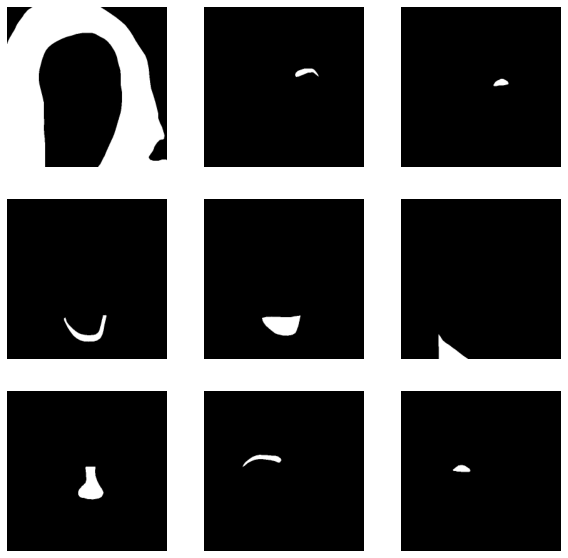

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in masks.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
from matplotlib import pyplot as plt


image = tf.keras.utils.load_img(
    "C:/Users/jconn/Downloads/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-img/0.jpg",
    grayscale=False,
    color_mode='rgb',
    target_size=None,
    interpolation='nearest'
)
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.expand_dims(image, 0)

image = tf.image.resize(image,(224,224))
print(image.shape)
out = vgg.predict(image)
print(out)

(1, 224, 224, 3)
[[3.83534982e-09 3.27219984e-09 2.94857827e-09 1.25893083e-08
  1.29284472e-09 3.26800853e-09 7.74147135e-10 3.32697816e-08
  2.26317489e-08 5.44270295e-10 7.16189885e-11 1.05102915e-09
  2.47577803e-09 4.33005987e-09 1.47775692e-09 1.00463513e-10
  9.20734669e-11 1.17610488e-09 5.72144665e-10 1.59383062e-09
  1.07476757e-10 8.64856520e-10 1.57911850e-09 6.64874289e-09
  1.56545553e-07 1.33853192e-10 2.99607866e-10 8.29572910e-10
  1.13183896e-09 2.39018610e-10 2.90282312e-11 3.68950204e-10
  3.65258768e-10 5.79947340e-11 6.63784305e-10 8.36254191e-11
  3.25977662e-10 8.59767188e-11 2.23380453e-10 1.16165377e-09
  2.15256901e-09 3.25879462e-10 2.83367396e-09 1.05043306e-07
  1.48792467e-09 6.79276635e-10 1.40005718e-09 7.45419282e-10
  4.85072038e-10 2.02450487e-10 7.12453152e-10 2.57736090e-08
  4.31636327e-09 2.07244821e-09 2.35985032e-09 6.49447329e-10
  2.30728703e-09 1.33894826e-10 6.83693102e-11 3.02791259e-09
  1.87071354e-08 1.23266322e-08 2.56913357e-09 1.7011